# Numba Demo 1

## Sum of first X integers

Given this simple function:

$$sum(x) = \sum\limits_{x=0}^X x$$

Lets define $sum_p(x)$ in pure Python

In [1]:
def sum_p(X):
    y = 0
    for x_i in range(int(X)):
        y += x_i
    return y

Then we define $sum_j(x)$ that is identical but just with decorator `@jit` in the definition.

In [2]:
from numba import jit

@jit
def sum_j(X):
    y = 0
    for x_i in range(int(X)):
        y += x_i
    return y

## Lets benchmark them!

Lets define a benchmark to study perfromances of our implementations of $sum(x)$:

In [3]:
import os
import time
import pandas as pd
import matplotlib
%matplotlib inline

# Different platforms require different functions to properly measure current timestamp:
if os.name == 'nt':
    now = time.clock
else:
    now = time.time

def run_benchmarks(functions, call_parameters, num_times,
                   logy=False, logx=False):
    
    # Executes one function several times and measure performances:
    def _apply_function(function, num_times):
        for j in range(num_times):
            t_0 = now()
            y = function(*call_parameters)
            duration = (now() - t_0)
            yield float(duration)
    
    def _name(function):
        return '${' + function.__name__ + '(x)}$'
    
    # Execute all functions the requested number of times and collects durations:
    def _apply_functions(functions, num_times):
        for function in functions:
            yield pd.Series(_apply_function(function, num_times),
                            name=_name(function))
            
            
    # Collects and plots the results:
    df = pd.concat(_apply_functions(functions, num_times),
                   axis=1)
    ax = df.plot(figsize=(10,5),
                 logy=logy,
                 logx=logx,
                 title='$T[f(x)]$ in seconds',
                 style='o-')


## Benchmark results

Lets measure them:

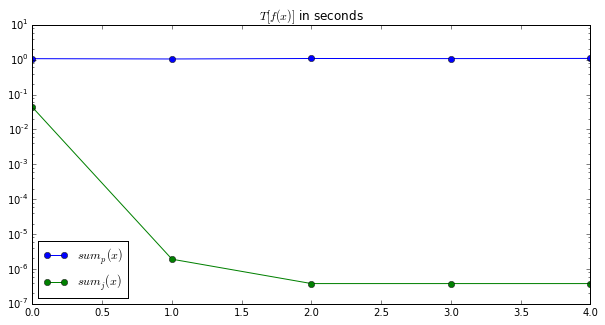

In [4]:
run_benchmarks(functions=[sum_p, sum_j],
               call_parameters=(10000000,),
               num_times=5,
               logy=True) # Logarithmic scale

## Numba caching

A second run to study `numba` caching mechanism

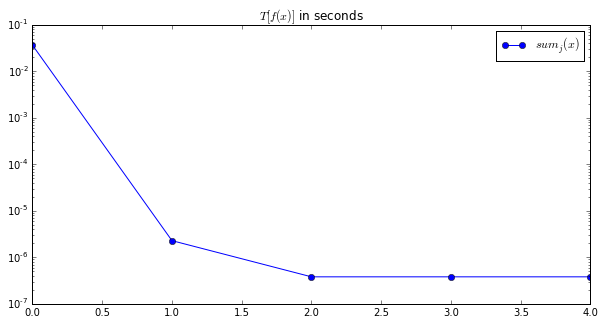

In [5]:
run_benchmarks(functions=[sum_j],
               call_parameters=(1000000000000000.,),
               num_times=5,
               logy=True) # Logarithmic scale

Numba JIT functionality works in the following way:
- At each call of a function $f(x)$, numba looks at the type $T$ of $x$.
- If it is the first time that type have been used generates a native implementation $f_T(x)$.
- If it is not  the first time that type have been used generates fetches the native implementation from a cache.
- Numba executes $f_T(x)$ that is orders of magnitudes faster than a pure Python implementation.

##And what about adding Cython to the game?

Lets define the same functon, but tuned to operate with floats:

$$sum(x) = \sum\limits_{x=0}^X x$$

We redefine it using `numba` and `cython`, this time using float numbers.

In [6]:
from numba import jit

@jit
def sum_j(x):
    y = 0.
    x_i = 0.
    while x_i < x:
        y += x_i
        x_i += 1.
    return y

In [7]:
%load_ext Cython

In [8]:
%%cython
def sum_c(double x):
    cdef double y = 0.
    cdef double x_i = 0.
    while x_i < x:
        y += x_i
        x_i += 1.
    return y

About Cython:
- generates C code from a Python code.
- allows to define low level C-types.
- in this example we use C-type `double`.
- C code is generated, compiled and executed.

## Benchmarks JIT vs Cython

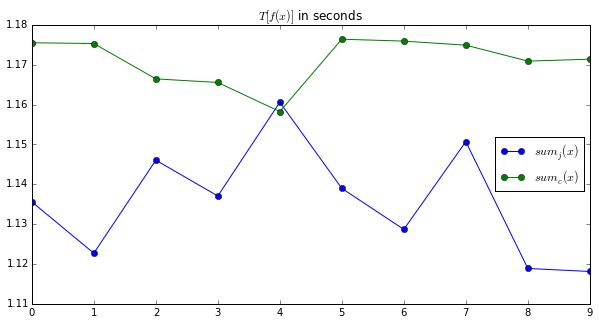

In [11]:
run_benchmarks(functions=[sum_j, sum_c],
               call_parameters=(1000000000.,),
               num_times=10)

The `numba` jitted function is comparable with the *cythonized* one, lets check what was the C code `cython` used, just to give us an idea of the efficiency of the code generated.

In [12]:
%%cython --annotate
def sum_c(double x):
    cdef double y = 0.
    cdef double x_i = 0.
    while x_i < x:
        y += x_i
        x_i += 1.
    return y

The function is in order, we have Python overhead only during the call and the return value to convert values from/to Python.

# Conclusions

Pure Python code can be 2-3 order of magnitudes slower than native code, but cheap solutions exists to solve the issue by makeing native just the parts where going native matters.

We have several ways of going native:

## Optiona A: C/C++ written Python extensions

Write C/C++ code and use it from Python.

It is sure the most powerful approach, but by far the more expensive.

Who develops C/C++ knows what does it mean:
- passing long hours waiting for a compiler to finish.
- never ending discussions about how to better pass parameters to functions.
- narrow set of 3rd party libraries, often complex to compile and integrate.
- very complicated generic programming.

In general, C++ is expensive and reserved to projects with a very big budget.

## Option B: use Cython

- Cython can generate C++ code for us from some code that we can define as *Python with types*.

- Sure is much cheaper than option A, but still forces us to assign typize our code.

- Choosing types requires some effort to understand what types we really need, and forces us to restrict the scope of our numerical functions.

- we have still something to compile again and again even if C is much faster than C++.

## Option C: try Numba and compile on the fly

- Numba allow us to have just in time code generation, and we can also omit types.

- The native code is to be generated on demand *where* and *when* needed with all the necessary information in place (types, target CPU, algorithmical context...)

- Another nice extra is to give to the user the Pythonic support for arbitrary big numbers.